In [21]:
# Trying tf probability

from __future__ import print_function
import collections
import matplotlib.pyplot as plt
import numpy as np
import math 
import os
import pandas as pd
import scipy 
import scipy.stats

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

# import tensorflow as tf
# import tensorflow.compat.v1 as tf
#tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# try:
#   tf.compat.v1.enable_eager_execution()
# except ValueError:
#   pass

from six.moves import urllib
import warnings

In [3]:
tf.enable_eager_execution()

In [3]:
n = tfd.Normal(loc = 0., scale = 1.)

In [8]:
test = n.log_prob(n.sample(10))

In [19]:
# Reshape Manipulation

six_way_multinomial = tfd.Multinomial(total_count = 1000., probs = [.3, .25, .2, .15, .08, .02])
six_way_multinomial

<tfp.distributions.Multinomial 'Multinomial' batch_shape=[] event_shape=[6] dtype=float32>

In [24]:
# Now we can tranform the event shape dimension 
transformed_multinomial = tfd.TransformedDistribution(
    distribution=six_way_multinomial,
    bijector=tfb.Reshape(event_shape_out=[2, 3]))
transformed_multinomial


<tfp.distributions.TransformedDistribution 'reshapeMultinomial' batch_shape=[] event_shape=[2, 3] dtype=float32>

In [25]:
# Now we can evaluate likelihood of the appropriately shaped object
transformed_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])


<tf.Tensor: id=175, shape=(), dtype=float32, numpy=-178.21924>

In [2]:
# Now something more complicated: COVARIANCE ESTIMATION

# We're assuming 2-D data with a known true mean of (0, 0)
true_mean = np.zeros([2], dtype=np.float32)
# We'll make the 2 coordinates correlated
true_cor = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float32)
# And we'll give the 2 coordinates different variances
true_var = np.array([4.0, 1.0], dtype=np.float32)
# Combine the variances and correlations into a covariance matrix
true_cov = np.expand_dims(np.sqrt(true_var), axis=1).dot(np.expand_dims(np.sqrt(true_var), axis=1).T) * true_cor
# We'll be working with precision matrices, so we'll go ahead and compute the
# true precision matrix here
true_precision = np.linalg.inv(true_cov)

In [3]:
print(true_cov)
print('eigenvalues:', np.linalg.eigvals(true_cov))

[[4.  1.8]
 [1.8 1. ]]
eigenvalues: [4.843075   0.15692513]


In [4]:
np.random.seed(123)
my_data = np.random.multivariate_normal(mean = true_mean, 
                                        cov = true_cov, 
                                        size = 100,
                                        check_valid = 'ignore').astype(np.float32)
my_data.shape

(100, 2)

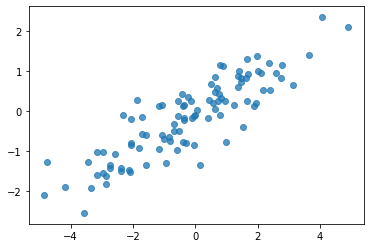

In [5]:
# Do a scatter plot
plt.scatter(my_data[:, 0], my_data[:, 1], alpha = 0.75)

In [6]:
print('mean of observations:', np.mean(my_data, axis=0))
print('true mean:', true_mean)

mean of observations: [-0.24009615 -0.16638893]
true mean: [0. 0.]


In [7]:
# Implement likelihood function
def log_lik_data_numpy(precision, data):
  # np.linalg.inv is a really inefficient way to get the covariance matrix, but
  # remember we don't care about speed here
  cov = np.linalg.inv(precision)
  rv = scipy.stats.multivariate_normal(true_mean, cov)
  return np.sum(rv.logpdf(data))

# test case: compute the log likelihood of the data given the true parameters
log_lik_data_numpy(true_precision, my_data)

-280.81822950593767

In [8]:
# Define priors
PRIOR_DF = 3
PRIOR_SCALE = np.eye(2, dtype = np.float32) / PRIOR_DF

def log_lik_prior_numpy(precision):
    rv = scipy.stats.wishart(df = PRIOR_DF, scale = PRIOR_SCALE)
    return rv.logpdf(precision)

log_lik_prior_numpy(true_precision)

-9.103606346649766

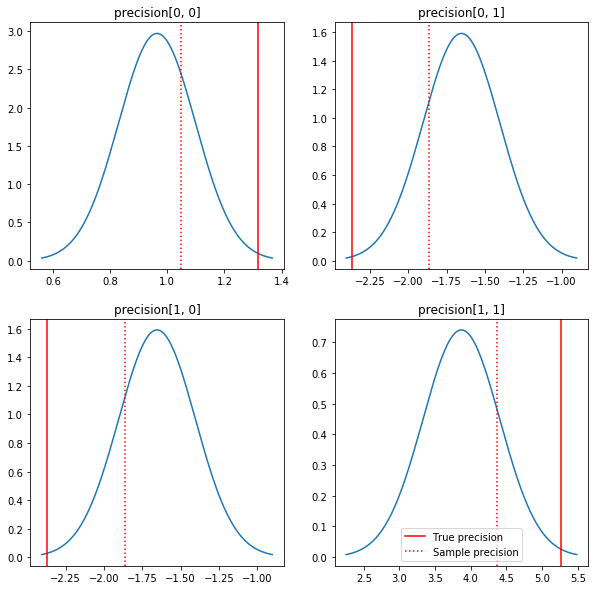

In [9]:
#  Getting analytical posteriors
n = my_data.shape[0]
nu_prior = PRIOR_DF
v_prior = PRIOR_SCALE
nu_posterior = nu_prior + n
v_posterior = np.linalg.inv(np.linalg.inv(v_prior) + my_data.T.dot(my_data))
posterior_mean = nu_posterior * v_posterior
v_post_diag = np.expand_dims(np.diag(v_posterior), axis=1)
posterior_sd = np.sqrt(nu_posterior *
                       (v_posterior ** 2.0 + v_post_diag.dot(v_post_diag.T)))

# Plot
sample_precision = np.linalg.inv(np.cov(my_data, rowvar=False, bias=False))
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    loc = posterior_mean[i, j]
    scale = posterior_sd[i, j]
    xmin = loc - 3.0 * scale
    xmax = loc + 3.0 * scale
    x = np.linspace(xmin, xmax, 1000)
    y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
    ax.plot(x, y)
    ax.axvline(true_precision[i, j], color='red', label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':', label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.legend()
plt.show()

In [10]:
# NOW USING TF PROBABILITY

In [11]:
# Data log likelihood
VALIDATE_ARGS = True
ALLOW_NAN_STATS = False

In [12]:
def log_lik_data(precisions, replicated_data):
  n = tf.shape(precisions)[0]  # number of precision matrices
  # We're estimating a precision matrix; we have to invert to get log
  # probabilities.  Cholesky inversion should be relatively efficient,
  # but as we'll see later, it's even better if we can avoid doing the Cholesky
  # decomposition altogether.
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [13]:
# Make replicated data
n = 2
replicated_data = np.tile(np.expand_dims(my_data, axis = 1), reps = [1, 2, 1])
print(replicated_data.shape)

(100, 2, 2)


In [14]:
# Check against the numpy implemention
precisions = np.stack([np.eye(2, dtype = np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_data(precisions, replicated_data = replicated_data).numpy()

for i in range(n):
    print(i)
    print('numpy: ', log_lik_data_numpy(precisions[i], my_data))
    print('tensorflow: ', lik_tf[i])

0
numpy:  -430.71218815801365
tensorflow:  -430.71207
1
numpy:  -280.81822950593767
tensorflow:  -280.8182


In [15]:
@tf.function(autograph = False)
def log_lik_prior(precisions):
    rv_precision = tfd.Wishart(
      df = PRIOR_DF,
      scale_tril = tf.linalg.cholesky(PRIOR_SCALE),
      validate_args = VALIDATE_ARGS,
      allow_nan_stats = ALLOW_NAN_STATS)
    return rv_precision.log_prob(precisions)

In [16]:
# check against the numpy implementation
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_prior(precisions).numpy()

for i in range(n):
    print(i)
    print('numpy:', log_lik_prior_numpy(precisions[i]))
    print('tensorflow:', lik_tf[i])

0
numpy: -2.2351873809649625
tensorflow: -2.2351875
1
numpy: -9.103606346649766
tensorflow: -9.103608


In [17]:
# Get log Likelihood
def get_log_lik(data, n_chains = 1):
    # The data argument that is passed in will be available to the inner function
    # below so it doesn't have to be passed in as a parameter.
    replicated_data = np.tile(np.expand_dims(data, axis = 1), reps = [1, n_chains, 1])

    @tf.function(autograph = False)
    def _log_lik(precision):
        return log_lik_data(precision, replicated_data) + log_lik_prior(precision)

    return _log_lik

In [18]:
@tf.function(autograph = False)
def sample():
    tf.random.set_seed(123)
    init_precision = tf.expand_dims(tf.eye(2), axis = 0)

    # Use expand_dims because we want to pass in a tensor of starting values
    log_lik_fn = get_log_lik(my_data, n_chains = 1)

    # we'll just do a few steps here
    num_results = 10
    num_burnin_steps = 10
    states = tfp.mcmc.sample_chain(
     num_results = num_results,
     num_burnin_steps = num_burnin_steps,
     current_state = [
         init_precision,
     ],
     kernel=tfp.mcmc.HamiltonianMonteCarlo(
         target_log_prob_fn = log_lik_fn,
         step_size = 0.1,
         num_leapfrog_steps = 3,
         seed = 123),
     trace_fn = None,
     parallel_iterations = 1)
    return states

try:
    states = sample()
except Exception as e:
    # shorten the giant stack trace
    lines = str(e).split('\n')
    print('\n'.join(lines[:5]+['...'] + lines[-3:]))

 Cholesky decomposition was not successful. The input might not be valid.
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_71/smart_for_loop/while/body/_349/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_491/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/StatefulPartitionedCall/Cholesky}}]] [Op:__inference_sample_1772]

Function call stack:
sample
...
Function call stack:
sample



In [20]:
def get_log_lik_verbose(data, n_chains=1):
    # The data argument that is passed in will be available to the inner function
    # below so it doesn't have to be passed in as a parameter.
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

    def _log_lik(precisions):
        # An internal method we'll make into a TensorFlow operation via tf.py_func
        def _print_precisions(precisions):
            print('precisions:\n', precisions)
            return False  # operations must return something!
        # Turn our method into a TensorFlow operation
        print_op = tf.compat.v1.py_func(_print_precisions, [precisions], tf.bool)

        # Assertions are also operations, and some care needs to be taken to ensure
        # that they're executed
        assert_op = tf.assert_equal(
            precisions, tf.linalg.matrix_transpose(precisions),
            message = 'not symmetrical', summarize=4, name='symmetry_check')

        # The control_dependencies statement forces its arguments to be executed
        # before subsequent operations
        with tf.control_dependencies([print_op, assert_op]):
            return (log_lik_data(precisions, replicated_data) +
                  log_lik_prior(precisions))

    return _log_lik

In [21]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  init_precision = tf.eye(2)[tf.newaxis, ...]
  log_lik_fn = get_log_lik_verbose(my_data)
  # we'll just do a few steps here
  num_results = 10
  num_burnin_steps = 10
  states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          init_precision,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3,
          seed=123),
      trace_fn=None,
      parallel_iterations=1)

try:
  states = sample()
except Exception as e:
  # shorten the giant stack trace
  lines = str(e).split('\n')
  print('\n'.join(lines[:5]+['...']+lines[-3:]))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
precisions:
 [[[1. 0.]
  [0. 1.]]]
precisions:
 [[[1. 0.]
  [0. 1.]]]
precisions:
 [[[ 0.17633379 -0.43482423]
  [-0.48801905  1.0519004 ]]]
 assertion failed: [not symmetrical] [Condition x == y did not hold element-wise:] [x (leapfrog_integrate_one_step/add:0) = ] [[[0.176333785 -0.434824228][-0.488019049 1.05190039]]] [y (

In [22]:
# Our transform has 3 stages that we chain together via composition:
precision_to_unconstrained = tfb.Chain([
    # step 3: flatten the lower triangular portion of the matrix
    tfb.Invert(tfb.FillTriangular(validate_args=VALIDATE_ARGS)),
    # step 2: take the log of the diagonals    
    tfb.TransformDiagonal(tfb.Invert(tfb.Exp(validate_args=VALIDATE_ARGS))),
    # step 1: decompose the precision matrix into its Cholesky factors
    tfb.Invert(tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS)),
])

In [23]:
m = tf.constant([[1., 2.], [2., 8.]])
m_fwd = precision_to_unconstrained.forward(m)
m_inv = precision_to_unconstrained.inverse(m_fwd)

# bijectors handle tensors of values, too!
m2 = tf.stack([m, tf.eye(2)])
m2_fwd = precision_to_unconstrained.forward(m2)
m2_inv = precision_to_unconstrained.inverse(m2_fwd)

print('single input:')
print('m:\n', m.numpy())
print('precision_to_unconstrained(m):\n', m_fwd.numpy())
print('inverse(precision_to_unconstrained(m)):\n', m_inv.numpy())
print()

print('tensor of inputs:')
print('m2:\n', m2.numpy())
print('precision_to_unconstrained(m2):\n', m2_fwd.numpy())
print('inverse(precision_to_unconstrained(m2)):\n', m2_inv.numpy())

single input:
m:
 [[1. 2.]
 [2. 8.]]
precision_to_unconstrained(m):
 [0.6931472 2.        0.       ]
inverse(precision_to_unconstrained(m)):
 [[1. 2.]
 [2. 8.]]

tensor of inputs:
m2:
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]
precision_to_unconstrained(m2):
 [[0.6931472 2.        0.       ]
 [0.        0.        0.       ]]
inverse(precision_to_unconstrained(m2)):
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]


In [26]:
def log_lik_prior_transformed(transformed_precisions):
  rv_precision = tfd.TransformedDistribution(
      tfd.Wishart(
          df=PRIOR_DF,
          scale_tril=tf.linalg.cholesky(PRIOR_SCALE),
          validate_args=VALIDATE_ARGS,
          allow_nan_stats=ALLOW_NAN_STATS),
      bijector=precision_to_unconstrained,
      validate_args=VALIDATE_ARGS)
  return rv_precision.log_prob(transformed_precisions)

In [27]:
# Check against the numpy implementation.  Note that when comparing, we need
# to add in the Jacobian correction.
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_prior_transformed(transformed_precisions).numpy()
corrections = precision_to_unconstrained.inverse_log_det_jacobian(
    transformed_precisions, event_ndims=1).numpy()
n = precisions.shape[0]

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
  print('tensorflow:', lik_tf[i])

0
numpy: -0.8488930160357633
tensorflow: -0.84889317
1
numpy: -7.305657151741624
tensorflow: -7.305659


In [28]:
def log_lik_data_transformed(transformed_precisions, replicated_data):
  # We recover the precision matrix by inverting our bijector.  This is
  # inefficient since we really want the Cholesky decomposition of the
  # precision matrix, and the bijector has that in hand during the inversion,
  # but we'll worry about efficiency later.
  n = tf.shape(transformed_precisions)[0]
  precisions = precision_to_unconstrained.inverse(transformed_precisions)
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [29]:
# sanity check
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_data_transformed(
    transformed_precisions, replicated_data).numpy()

for i in range(precisions.shape[0]):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


In [31]:
def get_log_lik_transformed(data, n_chains=1):
    # The data argument that is passed in will be available to the inner function
    # below so it doesn't have to be passed in as a parameter.
    replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

    @tf.function(autograph=False)
    def _log_lik_transformed(transformed_precisions):
        return (log_lik_data_transformed(transformed_precisions, replicated_data) +
                log_lik_prior_transformed(transformed_precisions))

    return _log_lik_transformed

In [32]:
# make sure everything runs
log_lik_fn = get_log_lik_transformed(my_data)
m = tf.eye(2)[tf.newaxis, ...]
lik = log_lik_fn(precision_to_unconstrained.forward(m)).numpy()
print(lik)

[-431.5611]


In [33]:
# We'll choose a proper random initial value this time
np.random.seed(123)
initial_value_cholesky = np.array(
    [[0.5 + np.random.uniform(), 0.0],
     [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
    dtype=np.float32)
initial_value =  initial_value_cholesky.dot(
  initial_value_cholesky.T)[np.newaxis, ...]

# The sampler works with unconstrained values, so we'll transform our initial
# value
initial_value_transformed = precision_to_unconstrained.forward(
  initial_value).numpy()

In [37]:
# Sample!
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_transformed(my_data, n_chains=1)

  num_results = 1000
  num_burnin_steps = 1000

  states, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          initial_value_transformed,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3,
          seed=123),
      trace_fn=lambda _, pkr: pkr.is_accepted,
      parallel_iterations=1)
  # transform samples back to their constrained form
  precision_samples = precision_to_unconstrained.inverse(states)
  return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample()

In [38]:
print('True posterior mean:\n', posterior_mean)
print('Sample mean:\n', np.mean(np.reshape(precision_samples, [-1, 2, 2]), axis=0))

True posterior mean:
 [[ 0.9641777 -1.6534657]
 [-1.6534657  3.8683152]]
Sample mean:
 [[ 1.4315274  -0.25587553]
 [-0.25587553  0.5740424 ]]


In [42]:
# NOW ADAPTIVE STEPSIZE

In [56]:
N_CHAINS = 3

np.random.seed(123)
initial_values = []
for i in range(N_CHAINS):
    initial_value_cholesky = np.array(
      [[0.5 + np.random.uniform(), 0.0],
       [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
      dtype = np.float32)
    initial_values.append(initial_value_cholesky.dot(initial_value_cholesky.T))

initial_values = np.stack(initial_values)
initial_values_transformed = precision_to_unconstrained.forward(
  initial_values).numpy()

In [60]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik_transformed(my_data)

    # Tuning acceptance rates:
    dtype = np.float32
    num_burnin_iter = 3000
    num_warmup_iter = int(0.8 * num_burnin_iter) 
    num_chain_iter = 2500

    # Set the target average acceptance ratio for the HMC as suggested by
    # Beskos et al. (2013):
    # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
    target_accept_rate = 0.651

    # Initialize the HMC sampler.
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn = log_lik_fn,
      step_size = 0.01,
      num_leapfrog_steps = 3)

    # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
    # of Andrieu and Thoms (2008):
    # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
    adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                      inner_kernel = hmc,
                      num_adaptation_steps = num_warmup_iter,
                      target_accept_prob = target_accept_rate)

    states, is_accepted = tfp.mcmc.sample_chain(
                          num_results = num_chain_iter,
                          num_burnin_steps = num_burnin_iter,
                          current_state = initial_values_transformed,
                          kernel = adapted_kernel,
                          trace_fn = lambda _, pkr: pkr.inner_results.is_accepted,
                          parallel_iterations = 1)
    
    # transform samples back to their constrained form
    precision_samples = precision_to_unconstrained.inverse(states)
    return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample()

In [61]:
print(np.mean(is_accepted))

0.6728


In [62]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641777 -1.6534657]
 [-1.6534657  3.8683152]]
Mean of samples:
 [[ 0.97088426 -1.6626079 ]
 [-1.6626079   3.8805084 ]]


In [63]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435489 0.25050807]
 [0.25050807 0.5390366 ]]
Standard deviation of samples:
 [[0.1339034  0.25206834]
 [0.25206834 0.54832774]]


In [64]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0025129 1.000433 ]
 [1.000433  1.0027605]]


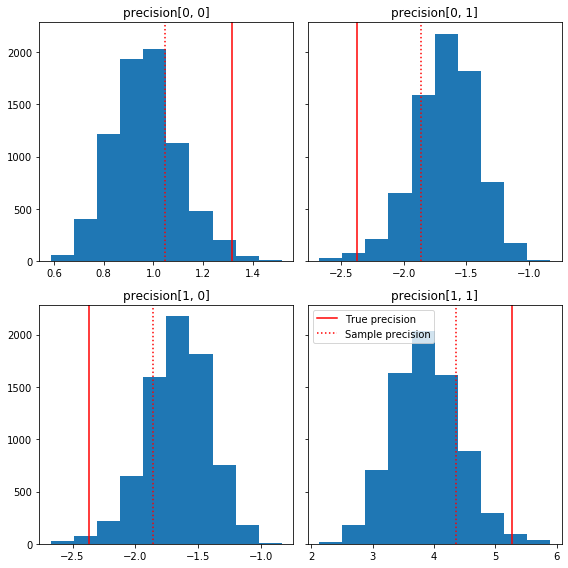

In [65]:
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(8, 8)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    ax.hist(precision_samples_reshaped[:, i, j])
    ax.axvline(true_precision[i, j], color='red',
               label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':',
               label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.tight_layout()
plt.legend()
plt.show()

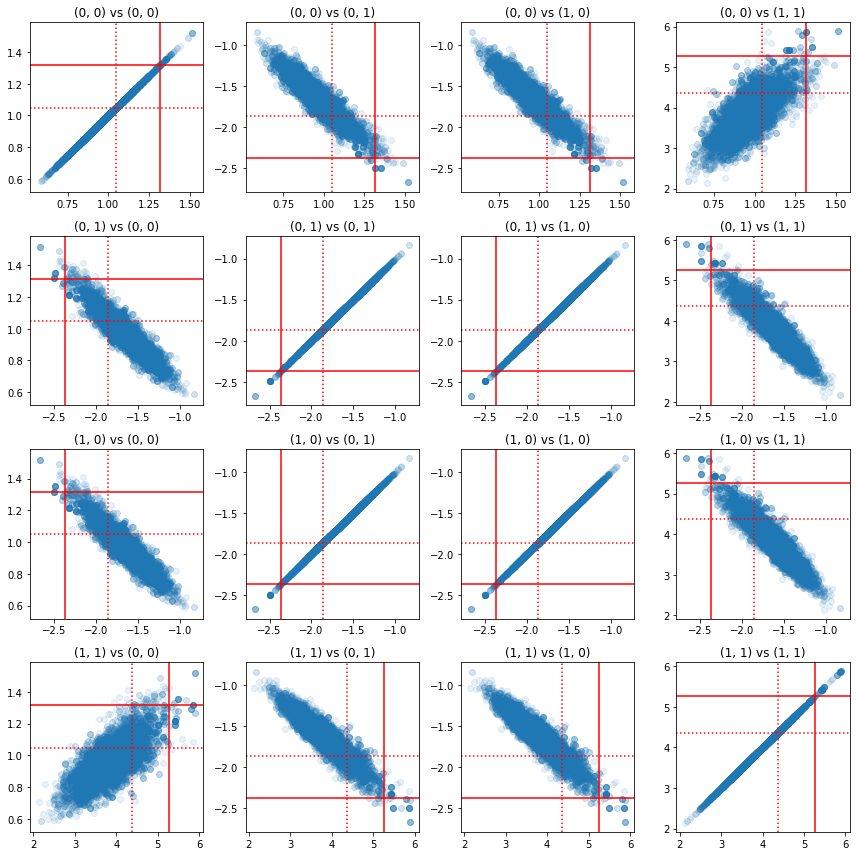

In [66]:
fig, axes = plt.subplots(4, 4)
fig.set_size_inches(12, 12)
for i1 in range(2):
  for j1 in range(2):
    index1 = 2 * i1 + j1
    for i2 in range(2):
      for j2 in range(2):
        index2 = 2 * i2 + j2
        ax = axes[index1, index2]
        ax.scatter(precision_samples_reshaped[:, i1, j1],
                   precision_samples_reshaped[:, i2, j2], alpha=0.1)
        ax.axvline(true_precision[i1, j1], color='red')
        ax.axhline(true_precision[i2, j2], color='red')
        ax.axvline(sample_precision[i1, j1], color='red', linestyle=':')
        ax.axhline(sample_precision[i2, j2], color='red', linestyle=':')
        ax.set_title('(%d, %d) vs (%d, %d)' % (i1, j1, i2, j2))
plt.tight_layout()
plt.show()

In [68]:
# WE CAN ALSO USE A TRANSFORMED TRANSITION KERNEL

In [69]:
# The bijector we need for the TransformedTransitionKernel is the inverse of
# the one we used above
unconstrained_to_precision = tfb.Chain([
    # step 3: take the product of Cholesky factors
    tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS),
    # step 2: exponentiate the diagonals    
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    # step 1: map a vector to a lower triangular matrix
    tfb.FillTriangular(validate_args=VALIDATE_ARGS),
])

In [70]:
@tf.function(autograph=False)
def sample():
    tf.random.set_seed(123)
    log_lik_fn = get_log_lik(my_data)

    # Tuning acceptance rates:
    dtype = np.float32
    num_burnin_iter = 3000
    num_warmup_iter = int(0.8 * num_burnin_iter) 
    num_chain_iter = 2500

    # Set the target average acceptance ratio for the HMC as suggested by
    # Beskos et al. (2013):
    # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
    target_accept_rate = 0.651

    # Initialize the HMC sampler.
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

    ttk = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstrained_to_precision)

    # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
    # of Andrieu and Thoms (2008):
    # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
    adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=ttk,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

    states = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values,
      kernel=adapted_kernel,
      trace_fn=None,
      parallel_iterations=1)
    # transform samples back to their constrained form
    return states

precision_samples  = sample()

In [71]:
# quick sanity check
m = [[1., 2.], [2., 8.]]
m_inv = unconstrained_to_precision.inverse(m).numpy()
m_fwd = unconstrained_to_precision.forward(m_inv).numpy()

print('m:\n', m)
print('unconstrained_to_precision.inverse(m):\n', m_inv)
print('forward(unconstrained_to_precision.inverse(m)):\n', m_fwd)

m:
 [[1.0, 2.0], [2.0, 8.0]]
unconstrained_to_precision.inverse(m):
 [0.6931472 2.        0.       ]
forward(unconstrained_to_precision.inverse(m)):
 [[1. 2.]
 [2. 8.]]


In [72]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641777 -1.6534657]
 [-1.6534657  3.8683152]]
Mean of samples:
 [[ 0.96622944 -1.6574398 ]
 [-1.6574398   3.8745546 ]]


In [73]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0029339 1.0005834]
 [1.0005834 1.0002747]]


In [76]:
# 8 Schools Experiment
from __future__ import absolute_import 
from __future__ import division
from __future__ import print_function

import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

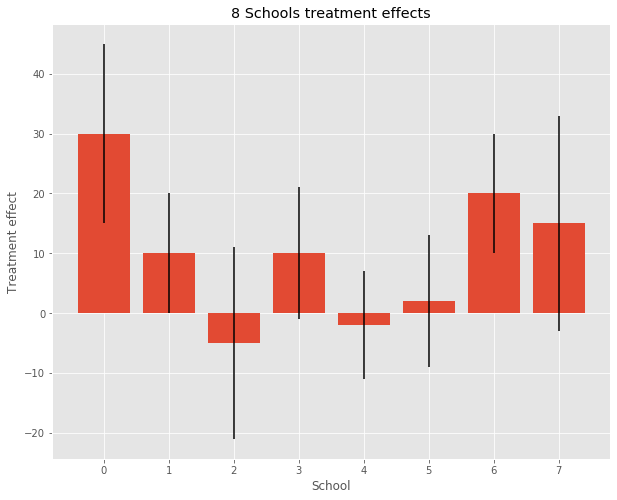

In [89]:
num_schools = 8
treatment_effects = np.array(
 [30, 10, -5, 10, -2, 2, 20, 15], dtype = np.float32)
# treatment_effects = np.array(
#  [28, 8, -3, 7, -1, 1, 18, 12], dtype = np.float32) # treatment effects
treatment_stddevs = np.array(
 [15, 10, 16, 11, 9, 11, 10, 18], dtype = np.float32) # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [90]:
model = tfd.JointDistributionSequential([
  tfd.Normal(loc = 0., scale = 10., name = "avg_effect"),  # `mu` above
  tfd.Normal(loc = 5., scale = 1., name = "avg_stddev"),  # `log(tau)` above
  tfd.Independent(tfd.Normal(loc = tf.zeros(num_schools),
                             scale = tf.ones(num_schools),
                             name = "school_effects_standard"),  # `theta_prime` 
                             reinterpreted_batch_ndims = 1),
  lambda school_effects_standard, avg_stddev, avg_effect: (
      tfd.Independent(tfd.Normal(loc = (avg_effect[..., tf.newaxis] +
                                      tf.exp(avg_stddev[..., tf.newaxis]) *
                                      school_effects_standard),  # `theta` above
                                 scale = treatment_stddevs),
                      name = "treatment_effects",  # `y` above
                      reinterpreted_batch_ndims = 1))
])

def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  # Note: We rely on the fact that treatment effects are specified outside of the function
  return model.log_prob((
      avg_effect, avg_stddev, school_effects_standard, treatment_effects)) 

In [91]:
num_results = 5000
num_burnin_steps = 3000

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph = False)
def do_sampling():
    return tfp.mcmc.sample_chain(
      num_results = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state = [
          tf.zeros([], name = 'init_avg_effect'),
          tf.zeros([], name = 'init_avg_stddev'),
          tf.ones([num_schools], name = 'init_school_effects_standard'),
      ],
      kernel = tfp.mcmc.HamiltonianMonteCarlo(
                      target_log_prob_fn = target_log_prob_fn,
                      step_size = 0.4,
                      num_leapfrog_steps = 3))

states, kernel_results = do_sampling()

avg_effect, avg_stddev, school_effects_standard = states

school_effects_samples = (
    avg_effect[:, np.newaxis] +
    np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)

num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.592


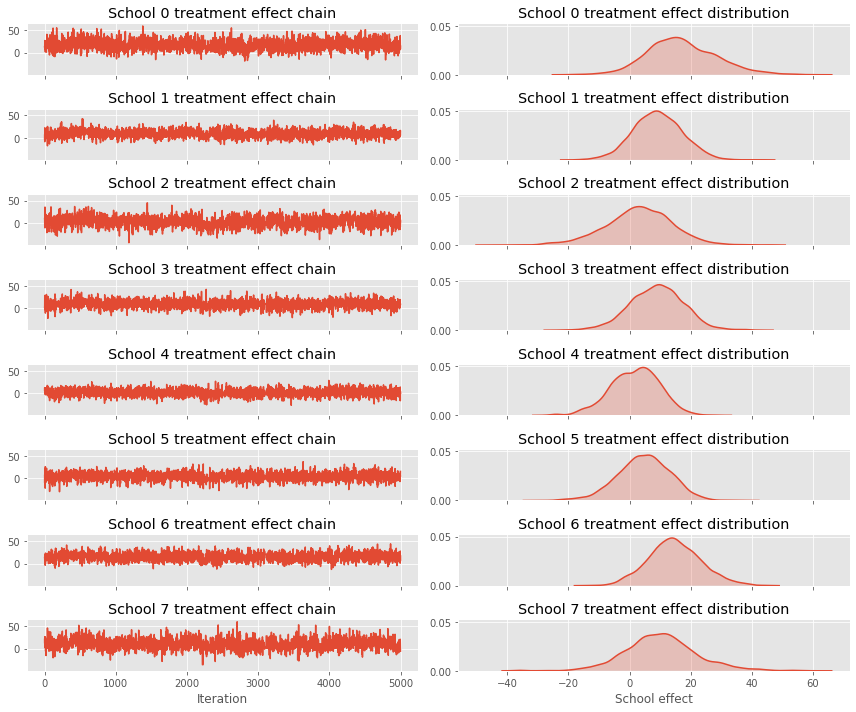

In [92]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i].numpy())
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i].numpy(), ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [93]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effects_standard] =")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

E[avg_effect] = 7.83059549331665
E[avg_stddev] = 2.4998044967651367
E[school_effects_standard] =
0.054583956
E[school_effects] =
[17.138912   9.24824    3.0659854  8.955099   1.8427252  4.7586565
 14.831589  10.366892 ]


In [94]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

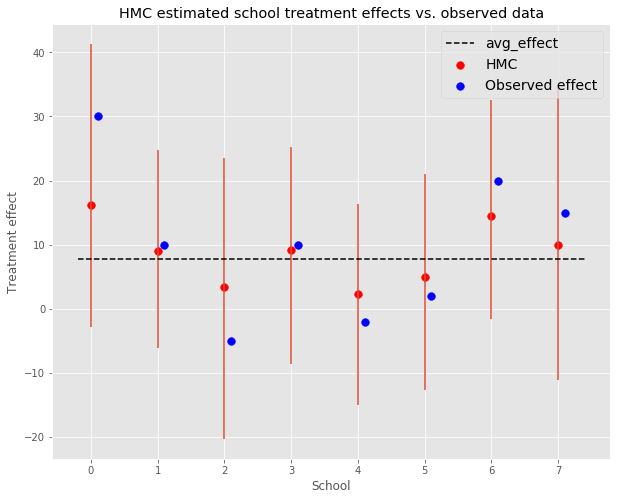

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                       np.mean(avg_effect)], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

In [13]:
# Bayesian Gaussian Mixture
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')

def cache_or_download_file(cache_dir, url_base, filename):
    """Read a cached file or download it."""
    filepath = os.path.join(cache_dir, filename)
    if tf.io.gfile.exists(filepath):
        return filepath
    if not tf.io.gfile.exists(cache_dir):
        tf.io.gfile.makedirs(cache_dir)
    url = os.path.join(url_base, filename)
    print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
    urllib.request.urlretrieve(url, filepath)
    return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
    """Download the radon dataset and read as Pandas dataframe."""
    url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
    # Alternative source:
    # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
    #             'master/reference/data/')
    srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
    srrs2.rename(columns=str.strip, inplace=True)
    cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
    cty.rename(columns=str.strip, inplace=True)
    return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
    """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
    srrs2 = srrs2[srrs2.state==state].copy()
    cty = cty[cty.st==state].copy()

    # We will now join datasets on Federal Information Processing Standards
    # (FIPS) id, ie, codes that link geographic units, counties and county
    # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
    srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
    cty['fips'] = 1000 * cty.stfips + cty.ctfips

    df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
    df = df.drop_duplicates(subset='idnum')
    df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})

    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)

    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
    county_name = map(str.strip, county_name)

    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
    df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
    return df, county_name

In [14]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())

In [15]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


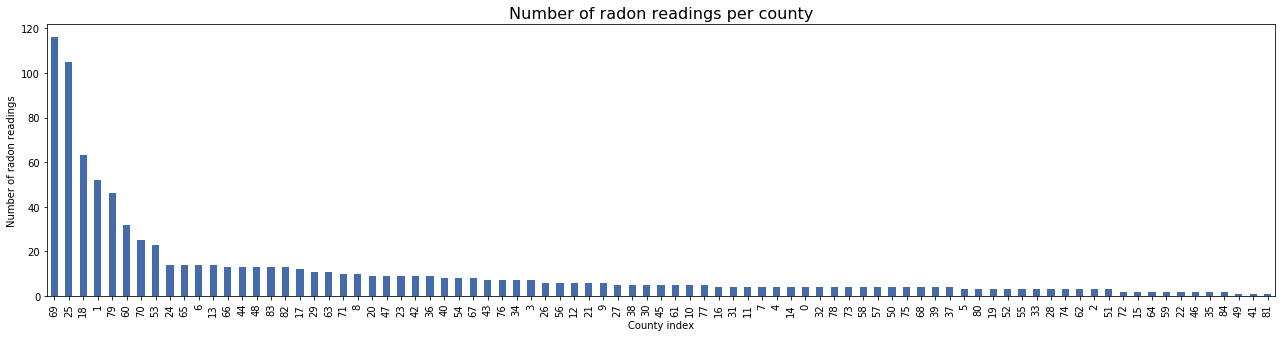

In [16]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

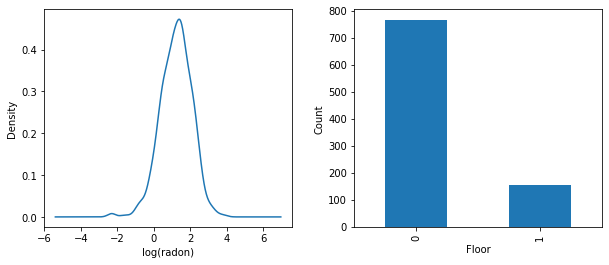

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

In [24]:
# Handy snippet to reset the global graph and global session.
tf.reset_default_graph()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()

AttributeError: module 'tensorflow_core.compat.v2' has no attribute 'InteractiveSession'

In [25]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

In [26]:

def _make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.get_variable(
      name='raw_prior_scale',
      initializer=np.array(inv_scale_transform(1.), dtype=dtype))
    return tfp.distributions.Independent(
          tfp.distributions.Normal(
              loc=tf.zeros(num_counties, dtype=dtype),
              scale=fwd_scale_transform(raw_prior_scale)),
          reinterpreted_batch_ndims=1)


make_weights_prior = tf.make_template(
    name_='make_weights_prior', func_=_make_weights_prior)

AttributeError: module 'tensorflow_core.compat.v2' has no attribute 'make_template'